# Predicting Omega
Given a trained network use this document to predict the values of Omega to produce a desired $J_{i,j}$.


In [34]:
import sys
sys.path.insert(0, '/Users/marinadrygala/Desktop/Marina/JijCalculator')
import classesmu
from classesmu import BatchSimulatedSpinLattice as bsslmu
from classesmu import SimulatedSpinLattice as sslmu
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time
import ic_functions
from ic_functions import chain, circle, torch_normalized, np_normalized, noise_adder
import neural_nets
from neural_nets import Net
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Instructions
Enter the path of the saved model to the path variable.

In [35]:
path = '/Users/marinadrygala/Desktop/Marina/mu_fixed/non_norm/N=10/m=10_Data_Size_25000_Error_0.2235_Time_1416.38_Epochs_79.pt'
d = torch.load(path)
"""The required items from the file are stored as variables."""
ic = d['ic']
N=ic.n

mu=d['mu']
m=d['m']

input_size = d['input_size']
hidden_size = d['hidden_size']
output_size = d['output_size']

"""The trained model is loaded"""
model = Net(input_size, hidden_size, output_size,1)
model.load_state_dict(d['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(d['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.double()

model.double()



Net(
  (input_layer): Linear(in_features=45, out_features=1024, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (output_layer): Linear(in_features=1024, out_features=100, bias=True)
)

## Instructions C'td
Enter the desired $J_{i,j}$ value or set of values in the variable Jij. Note make sure the values are normalized by dividing by the L2-norm.

In [36]:
"""Network Predictions"""
#Jij = test_set[3]
Jij = chain(N)
Jij = torch.from_numpy(np_normalized(Jij))
if len(Jij.size())==1:
    Omega_pred = model(Jij).view(1,N,m)
else:
    Omega_pred = model(Jij).view(Jij.size()[0],N,m)
lattice = bsslmu(ic, mu, Omega_pred, dev=device)
Jij_pred = lattice.normalize()
Error = torch.mean(torch.abs(Jij-Jij_pred))*100
print('Predicted Omega values\n', Omega_pred)
print('Desired Jijs\n',Jij)
print('Jijs give by Omegas predicted\n', Jij_pred)
print('Mean error\n', Error.item())

Predicted Omega values
 tensor([[[ -5.3407,   0.4427,  -2.4059,  30.3201,   3.4563,   2.7111, -20.3155,
          -17.6967,  -4.8917,   5.5161],
         [ -7.0244,   4.2771, -10.9934, -14.2587,  -3.5560, -23.2911,   9.4470,
          -10.7996,  14.3122,   5.8711],
         [  0.4540,  22.6333,  16.7727,  10.0775, -21.3565,  -4.3559, -10.9327,
           15.0841,  -0.9172,   5.9159],
         [ -2.8649,   5.1988,  -2.6181,   4.0677, -28.0748,   3.9310,  -6.2807,
            3.7860,  -0.8733,  34.6135],
         [  3.3793, -14.3002,  -8.2917, -19.4439,  18.7780, -11.7766,  15.5624,
           -6.0692, -21.2794,  29.4171],
         [-41.8829,   2.0374,   1.0962,   0.7604,  -4.6083,  -1.2330,  -2.7412,
           -0.6350,  -0.0597,  -4.7024],
         [  5.9461,  12.3341,  -3.9378,  18.3012,  -4.5030,  13.8151,  18.3998,
           14.5902,  10.9302, -15.5805],
         [ -1.2918,  12.2404,  22.2475,  20.1479,  -3.8684,   2.7848,   9.0594,
           15.5440,   1.6041,   1.4441],
        

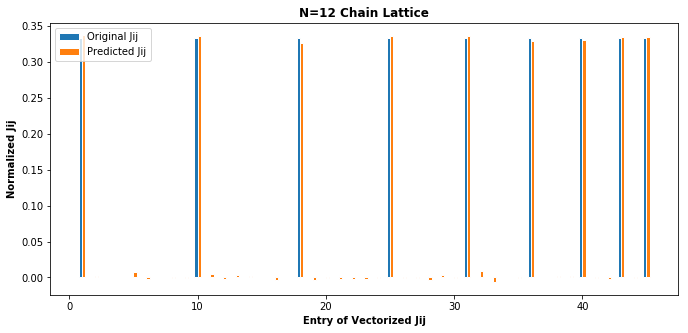

In [37]:
"""A bar graph to help one visalize the scales of the desired and original Jijs for a single Jij"""
if len(Jij.size())==1:
    size_Jij = int(N*(N-1)/2)
    x = range(1,size_Jij+1)

    plt.figure(figsize=(size_Jij/4,5))

    barWidth = 0.25
 
    bars1 = list(Jij.numpy())
    bars2 = list(Jij_pred.view(size_Jij).detach().numpy())

 
    
    r1 = [i - barWidth/2 for i in x]
    r2 = [i + barWidth/2 for i in x]


 
   
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Original Jij')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Predicted Jij')

 
    
    plt.xlabel('Entry of Vectorized Jij', fontweight='bold')
    plt.ylabel('Normalized Jij', fontweight='bold')
    plt.title('N=10 Chain Lattice', fontweight='bold')
 
    
    plt.legend()
    plt.show()


In [38]:
"""A comparision of the absolute sizes of the Rabi frequencies corresponding to each detuning. Used to predict which
mu value may be possible to eliminate and still retain some accuracy."""
numerator=torch.einsum('pnm->pm',[abs(Omega_pred)])
denominator=torch.einsum('pnm->p',[abs(Omega_pred)])
epsilon=torch.einsum('pm,p->m',[numerator,1/denominator])
norm_epsilon=torch.sqrt((epsilon ** 2).sum(0))
normalized_epsilon=epsilon/norm_epsilon

Text(0.5,1,'Scaled value')

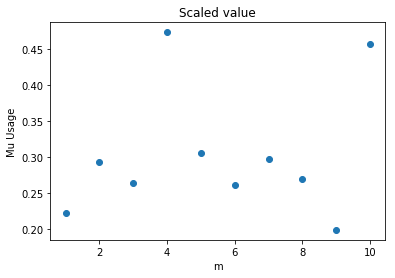

In [39]:
"""Visualization of the above calculations"""
plt.plot(range(1,len(epsilon)+1),list(normalized_epsilon),
            marker='o',linestyle='None')

plt.ylabel('Mu Usage')
plt.xlabel('m')
plt.title('Scaled value')

In [40]:
"""Determine which indices of the original mu were removed, incase the user wishes to remove more, and produce a
new data set."""
# print(d['removed_mus'])
# print(d['mu'])

'Determine which indices of the original mu were removed, incase the user wishes to remove more, and produce a\nnew data set.'